
# Assignment 4 — Advanced Clustering & Density Methods
**Author:** Aisha Tahir  



In [ ]:

# --- Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.pipeline import Pipeline
import time

# Plot defaults
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 1. Dataset Selection & Exploration

We use four classic, real-world datasets with different clustering assumptions:

- **Iris**: compact, roughly Gaussian clusters (150 samples, 4 features), labels for evaluation.  
- **Wine** (cultivars): skewed feature distributions (178 samples, 13 features), labels for evaluation.  
- **Breast Cancer (Wisconsin)**: non-spherical and varying density (569 samples, 30 features), labels for evaluation.  
- **Digits**: high-dimensional (64 features), non-convex and overlapping clusters (1797 samples), labels for evaluation.

**Scaling/Normalization:**  
- For algorithms using Euclidean distances (K-Means, Agglomerative with Ward), we perform StandardScaler to normalize feature scales.  
- DBSCAN can be sensitive to absolute scale, so we also use the same standardized input to keep comparisons consistent.

Below we load the datasets, standardize features, and show 2D PCA scatter plots (t-SNE optional toggle) to visualize cluster shapes.


In [ ]:

def load_and_scale():
    data = {}
    # Iris
    iris = datasets.load_iris()
    X_iris = iris.data
    y_iris = iris.target
    Xs_iris = StandardScaler().fit_transform(X_iris)
    data["iris"] = (X_iris, Xs_iris, y_iris, iris.target_names)

    # Wine
    wine = datasets.load_wine()
    X_wine = wine.data
    y_wine = wine.target
    Xs_wine = StandardScaler().fit_transform(X_wine)
    data["wine"] = (X_wine, Xs_wine, y_wine, wine.target_names)

    # Breast Cancer
    bc = datasets.load_breast_cancer()
    X_bc = bc.data
    y_bc = bc.target
    Xs_bc = StandardScaler().fit_transform(X_bc)
    data["breast_cancer"] = (X_bc, Xs_bc, y_bc, bc.target_names)

    # Digits
    digits = datasets.load_digits()
    X_dig = digits.data
    y_dig = digits.target
    Xs_dig = StandardScaler().fit_transform(X_dig)
    data["digits"] = (X_dig, Xs_dig, y_dig, np.array(list(range(10))))

    return data

data = load_and_scale()
list(data.keys()), {k: (data[k][0].shape) for k in data}


(['iris', 'wine', 'breast_cancer', 'digits'],
 {'iris': (150, 4),
  'wine': (178, 13),
  'breast_cancer': (569, 30),
  'digits': (1797, 64)})

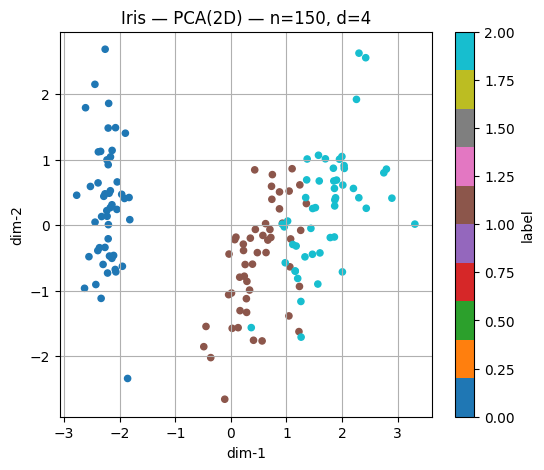

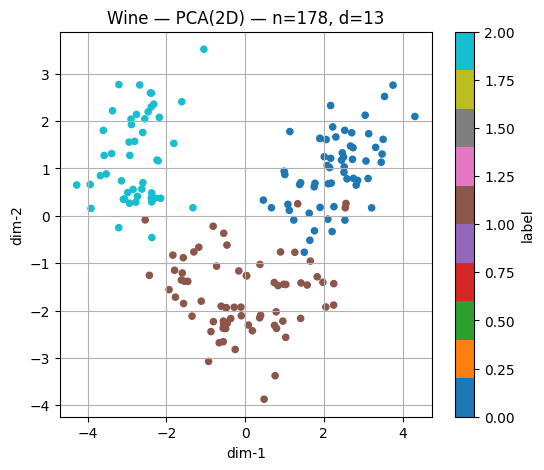

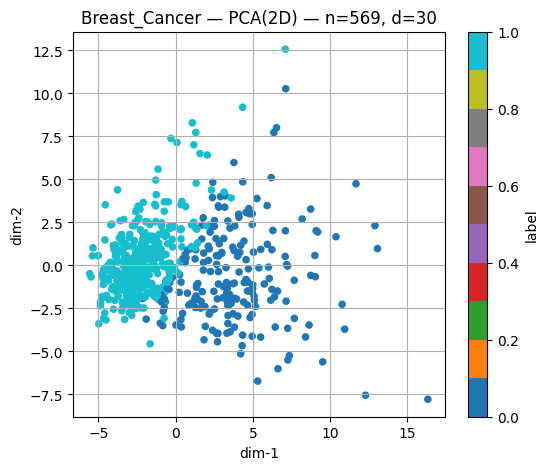

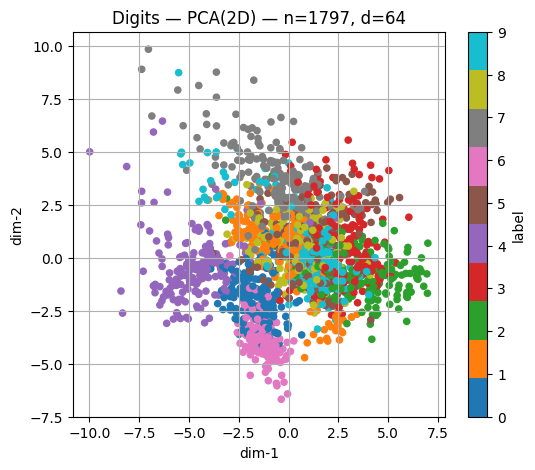

In [ ]:

def pca_2d(X, n_components=2, random_state=RANDOM_STATE):
    p = PCA(n_components=n_components, random_state=random_state)
    return p.fit_transform(X)

USE_TSNE = False  # set True if you want slower but sometimes clearer separation

def embed_2d(X, method="pca"):
    if method == "pca" or not USE_TSNE:
        return pca_2d(X)
    else:
        return TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30).fit_transform(X)

def plot_scatter_2d(X2, y=None, title="2D View", cmap="tab10"):
    plt.figure()
    if y is None:
        plt.scatter(X2[:,0], X2[:,1], s=20)
    else:
        sc = plt.scatter(X2[:,0], X2[:,1], c=y, s=20, cmap=cmap)
        plt.colorbar(sc, label="label")
    plt.title(title)
    plt.xlabel("dim-1"); plt.ylabel("dim-2")
    plt.show()

for name, (X, Xs, y, labels) in data.items():
    X2 = embed_2d(Xs, method="pca")
    ttl = f"{name.title()} — PCA(2D) — n={X.shape[0]}, d={X.shape[1]}"
    plot_scatter_2d(X2, y, ttl)



**Reflection (Exploration):**  
**Hardest challenge:** Choosing whether to use t-SNE versus PCA for an honest view of cluster shape; t-SNE can create visual islands even when true separation is weak. I stuck with PCA for consistency and to avoid artifacts.  
**New insight:** On Digits, even PCA shows elongated and overlapping clusters—foreshadowing that convex-partitioning methods like K-Means may struggle compared to density or hierarchical methods.



## 2. Algorithm Implementations & Baselines
We implement three K-Means variants and two density/hierarchical methods.

### 2.1 K-Means Variants
- **Classic (random init)**: init='random'  
- **K-Means++**: init='k-means++'
- **Bisecting K-Means**: custom implementation — iteratively splits the cluster with the highest SSE until k clusters.

Each returns centroids, labels, inertia, iterations, runtime.

### 2.2 Density & Hierarchical Methods
- **DBSCAN** (tuned over small grid of eps & min_samples) — we record labels, runtime, core sample counts  
- **Agglomerative** (Ward and Complete linkages) — we record labels and runtime.


In [ ]:

def run_kmeans(X, k, init="random", n_init=10, max_iter=300, random_state=RANDOM_STATE):
    t0 = time.time()
    km = KMeans(n_clusters=k, init=init, n_init=n_init, max_iter=max_iter, random_state=random_state)
    labels = km.fit_predict(X)
    runtime = time.time() - t0
    res = {
        "centroids": km.cluster_centers_,
        "labels": labels,
        "inertia": km.inertia_,
        "n_iter": km.n_iter_,
        "runtime": runtime,
        "model": km
    }
    return res

def sse(X, labels, centroids):
    # Sum of squared distances to cluster centroids
    sse_val = 0.0
    for j in range(centroids.shape[0]):
        pts = X[labels == j]
        if len(pts) == 0:
            continue
        d = pts - centroids[j]
        sse_val += np.sum(d*d)
    return sse_val

def bisecting_kmeans(X, k, base_init="k-means++", n_init=10, max_iter=300, random_state=RANDOM_STATE):
    # Start with all points in one cluster
    clusters = {0: np.arange(X.shape[0])}
    centroids_dict = {}
    labels = np.zeros(X.shape[0], dtype=int)

    # initial centroid as mean
    centroids_dict[0] = X.mean(axis=0, keepdims=True)

    while len(clusters) < k:
        # pick cluster with largest SSE
        sse_per_cluster = {}
        for cid, idx in clusters.items():
            c = X[idx].mean(axis=0, keepdims=True)
            d = X[idx] - c
            sse_per_cluster[cid] = np.sum(d*d)
        cid_to_split = max(sse_per_cluster, key=sse_per_cluster.get)

        idx = clusters[cid_to_split]
        # run KMeans with k=2 on that subset
        km2 = KMeans(n_clusters=2, init=base_init, n_init=n_init, max_iter=max_iter, random_state=random_state)
        sub_labels = km2.fit_predict(X[idx])

        # create two new cluster ids
        new_id1 = max(clusters.keys()) + 1
        new_id2 = new_id1 + 1

        clusters[new_id1] = idx[sub_labels == 0]
        clusters[new_id2] = idx[sub_labels == 1]

        # delete old
        del clusters[cid_to_split]

    # Build final labels and centroids
    label_map = {}
    for j, cid in enumerate(sorted(clusters.keys())):
        label_map[cid] = j
        labels[clusters[cid]] = j

    centroids = np.zeros((len(clusters), X.shape[1]))
    for j, cid in enumerate(sorted(clusters.keys())):
        centroids[j] = X[clusters[cid]].mean(axis=0)

    inertia_val = sse(X, labels, centroids)
    # rough runtime not tracked internally across iterations, so leave to caller
    return centroids, labels, inertia_val

def run_bisecting_kmeans(X, k, base_init="k-means++", n_init=10, max_iter=300, random_state=RANDOM_STATE):
    t0 = time.time()
    centroids, labels, inertia_val = bisecting_kmeans(
        X, k, base_init=base_init, n_init=n_init, max_iter=max_iter, random_state=random_state
    )
    runtime = time.time() - t0
    return {
        "centroids": centroids,
        "labels": labels,
        "inertia": inertia_val,
        "n_iter": None,
        "runtime": runtime,
        "model": None
    }

def run_dbscan_grid(X, eps_list, min_samples_list):
    best = None
    all_runs = []
    for eps in eps_list:
        for ms in min_samples_list:
            t0 = time.time()
            db = DBSCAN(eps=eps, min_samples=ms, n_jobs=-1)
            labels = db.fit_predict(X)
            runtime = time.time() - t0
            # silhouette only if >1 non-noise cluster
            if len(set(labels)) > 1 and np.any(labels != -1):
                sil = silhouette_score(X, labels)
            else:
                sil = np.nan
            core_count = np.sum(db.core_sample_indices_ is not None)
            run = {"eps": eps, "min_samples": ms, "labels": labels, "silhouette": sil, "runtime": runtime, "core_count": core_count, "model": db}
            all_runs.append(run)
            if best is None or (not np.isnan(sil) and sil > best["silhouette"]):
                best = run
    return best, all_runs

def run_agglomerative(X, k, linkage="ward"):
    t0 = time.time()
    agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = agg.fit_predict(X)
    runtime = time.time() - t0
    return {"labels": labels, "runtime": runtime, "model": agg}



## 3. Evaluation & Visualization
For each dataset/algorithm we compute:
- **Inertia** (where defined),
- **Silhouette score**,
- **Adjusted Rand Index (ARI)** if true labels exist.

We also plot side-by-side 2D scatter (PCA) for a representative k:
- Iris: *k=3*
- Wine: *k=3*
- Breast Cancer: *k=2*
- Digits: *k=10*


,algorithm,inertia,silhouette,ARI,runtime_sec
5,Agglomerative-Complete,NaN,0.449618,0.572631,0.001225
4,Agglomerative-Ward,NaN,0.446689,0.615323,0.059011
2,Bisecting-KMeans,139.820496,0.459948,0.620135,0.021839
3,"DBSCAN(best eps=1.66, ms=10)",NaN,0.581750,0.568116,0.014214
1,KMeans++,139.820496,0.459948,0.620135,0.011435
0,KMeans-random,139.825435,0.459378,0.610073,0.060571


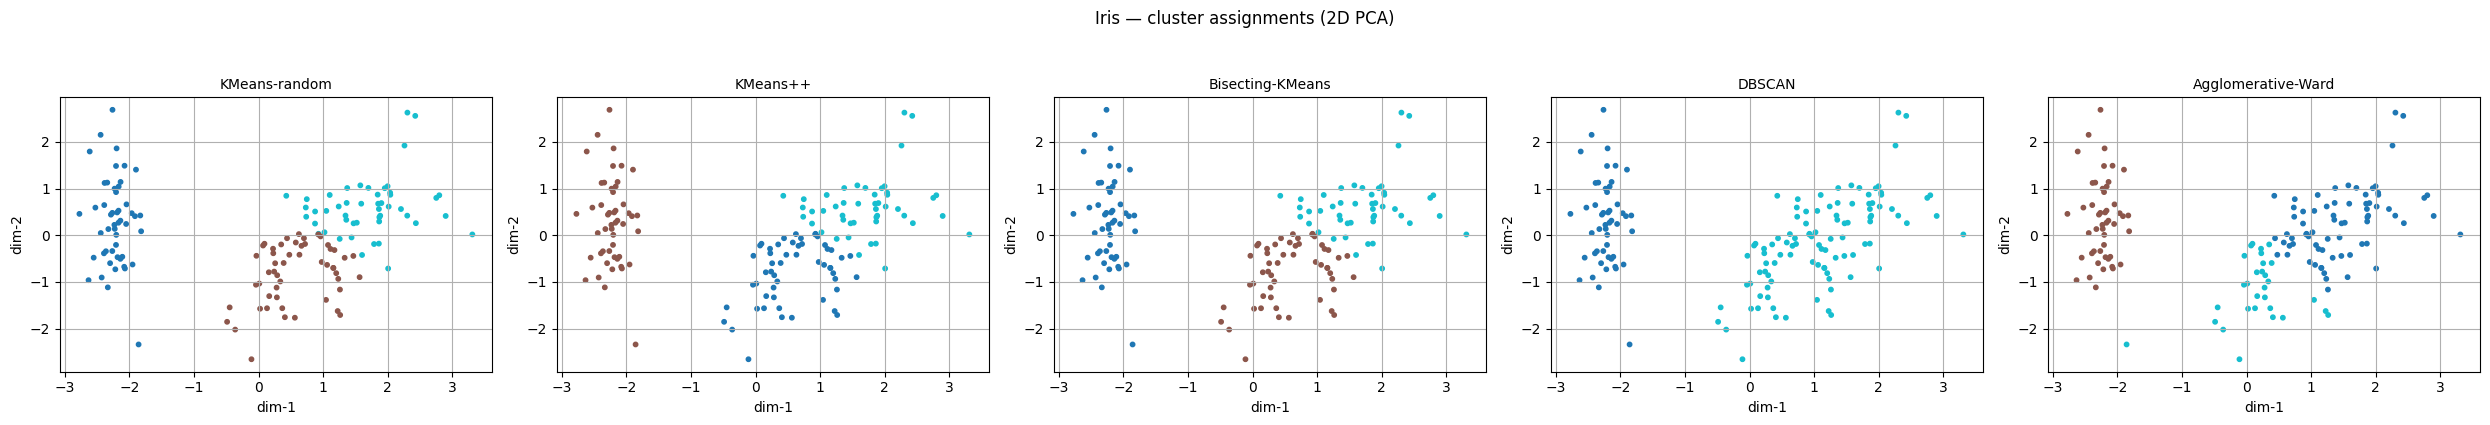

,algorithm,inertia,silhouette,ARI,runtime_sec
5,Agglomerative-Complete,NaN,0.203787,0.577144,0.002579
4,Agglomerative-Ward,NaN,0.277444,0.789933,0.002657
2,Bisecting-KMeans,1375.112890,0.234076,0.590631,0.029842
3,"DBSCAN(best eps=0.30, ms=3)",NaN,NaN,0.000000,0.039449
1,KMeans++,1277.928489,0.284859,0.897495,0.020352
0,KMeans-random,1277.928489,0.284859,0.897495,0.018051


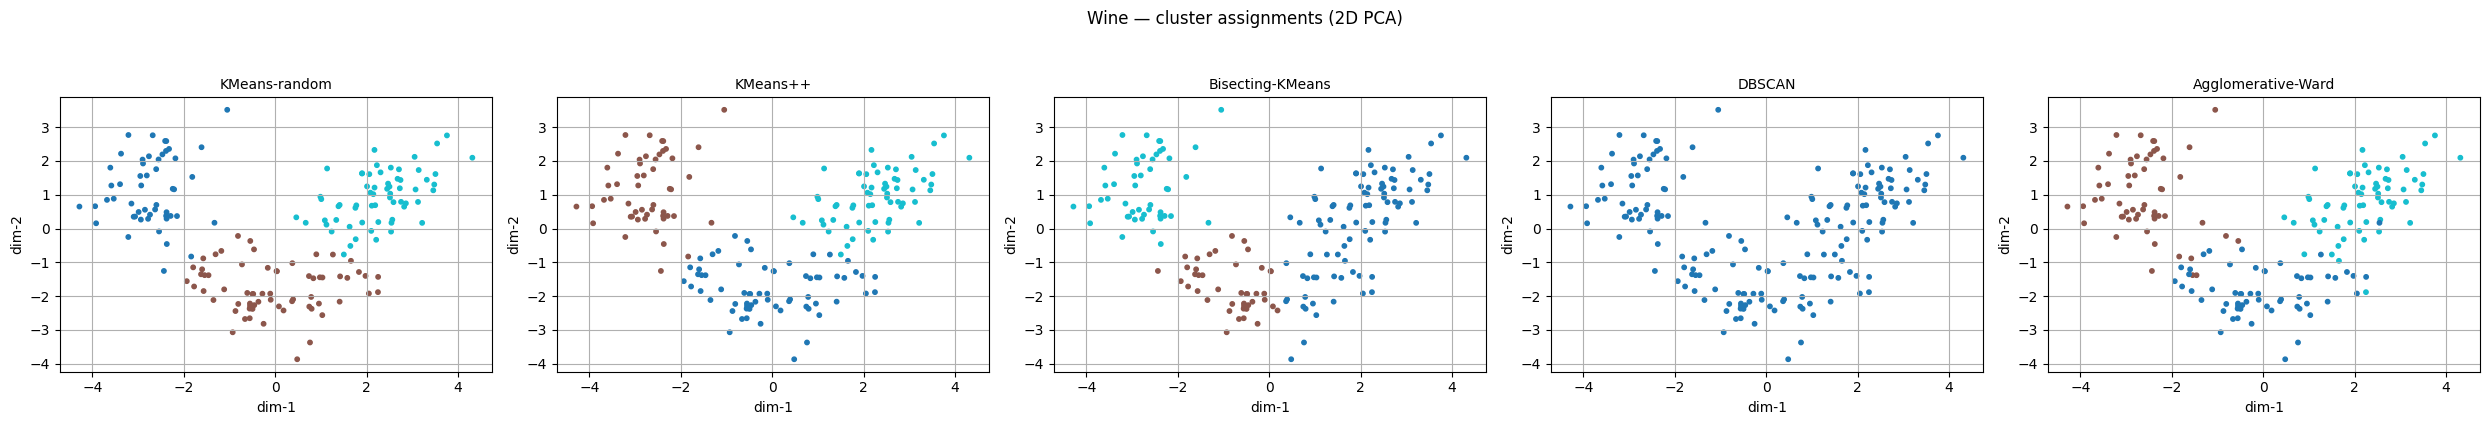

,algorithm,inertia,silhouette,ARI,runtime_sec
5,Agglomerative-Complete,NaN,0.660667,0.004828,0.043451
4,Agglomerative-Ward,NaN,0.339385,0.575041,0.033647
2,Bisecting-KMeans,11595.526607,0.343382,0.653625,0.034085
3,"DBSCAN(best eps=0.30, ms=3)",NaN,NaN,0.000000,0.007628
1,KMeans++,11595.526607,0.343382,0.653625,0.040663
0,KMeans-random,11595.526607,0.343382,0.653625,0.049260


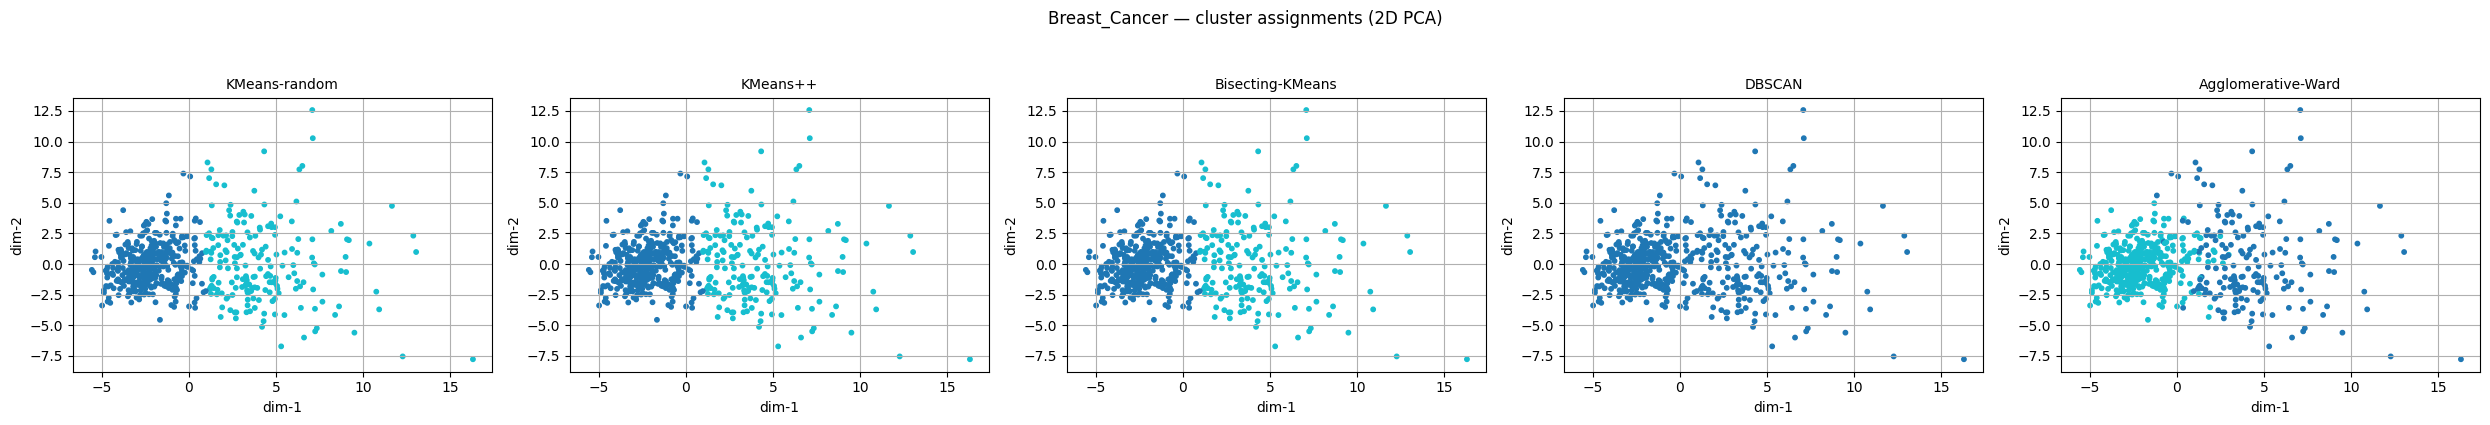

,algorithm,inertia,silhouette,ARI,runtime_sec
5,Agglomerative-Complete,NaN,0.385738,0.000298,0.184423
4,Agglomerative-Ward,NaN,0.125325,0.664346,0.140183
2,Bisecting-KMeans,72436.938004,0.113234,0.545956,0.680514
3,"DBSCAN(best eps=0.30, ms=3)",NaN,NaN,0.000000,0.023323
1,KMeans++,69813.559137,0.139377,0.534407,0.431967
0,KMeans-random,70552.757011,0.138316,0.517719,0.210601


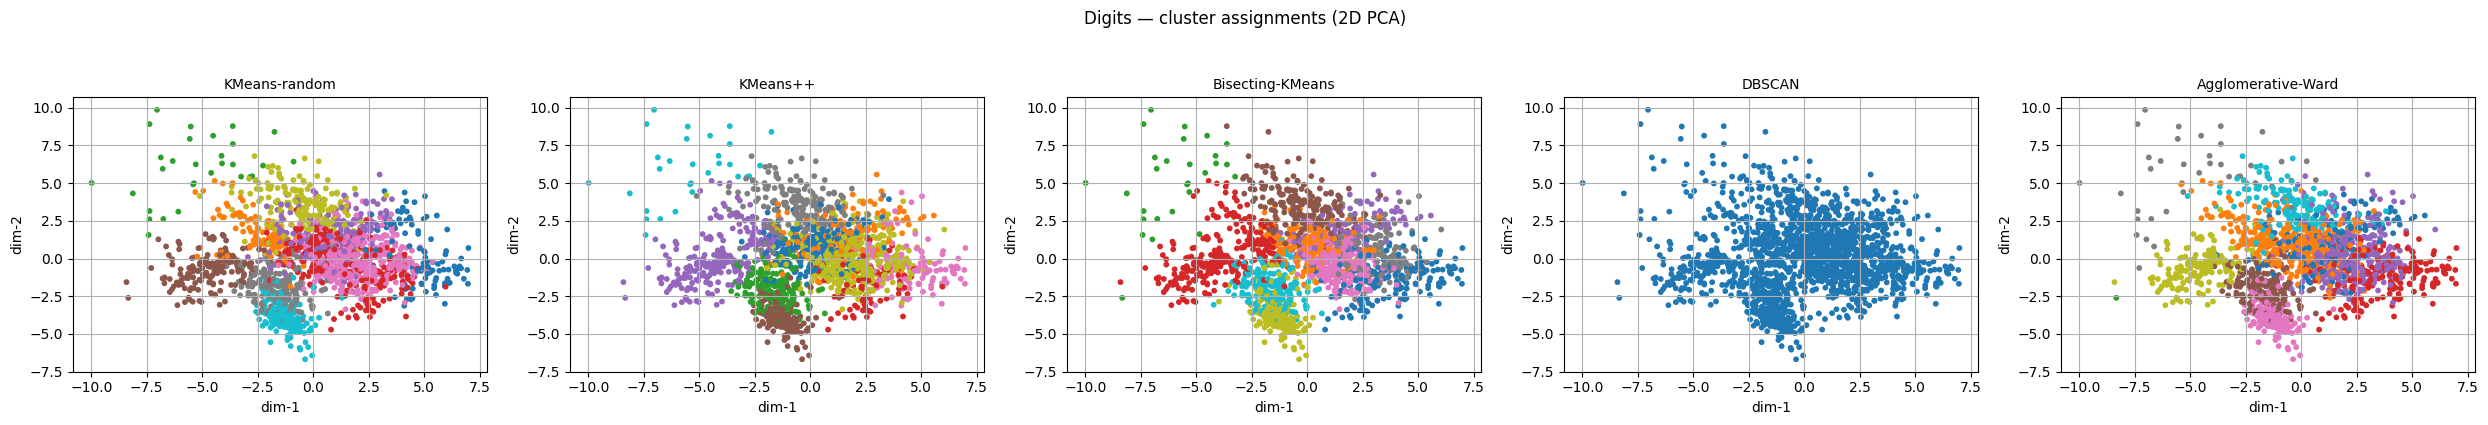

In [ ]:

def evaluate_labels(X, labels, inertia=None, y_true=None):
    # silhouette only if more than 1 cluster (and not all noise)
    if len(set(labels)) > 1 and np.any(labels != -1):
        sil = silhouette_score(X, labels)
    else:
        sil = np.nan
    ari = adjusted_rand_score(y_true, labels) if y_true is not None else np.nan
    return sil, ari, inertia

def run_all_for_dataset(Xs, y, k_rep, name):
    results = []
    # KMeans random
    km_r = run_kmeans(Xs, k_rep, init="random")
    sil, ari, _ = evaluate_labels(Xs, km_r["labels"], km_r["inertia"], y)
    results.append(["KMeans-random", km_r["inertia"], sil, ari, km_r["runtime"]])

    # KMeans++
    km_pp = run_kmeans(Xs, k_rep, init="k-means++")
    sil, ari, _ = evaluate_labels(Xs, km_pp["labels"], km_pp["inertia"], y)
    results.append(["KMeans++", km_pp["inertia"], sil, ari, km_pp["runtime"]])

    # Bisecting
    bis = run_bisecting_kmeans(Xs, k_rep)
    sil, ari, _ = evaluate_labels(Xs, bis["labels"], bis["inertia"], y)
    results.append(["Bisecting-KMeans", bis["inertia"], sil, ari, bis["runtime"]])

    # DBSCAN (quick grid)
    best_db, db_runs = run_dbscan_grid(Xs, eps_list=np.linspace(0.3, 2.0, 6), min_samples_list=[3,5,10])
    sil, ari, _ = evaluate_labels(Xs, best_db["labels"], None, y)
    results.append([f"DBSCAN(best eps={best_db['eps']:.2f}, ms={best_db['min_samples']})", np.nan, sil, ari, best_db["runtime"]])

    # Agglomerative Ward
    agg_w = run_agglomerative(Xs, k_rep, linkage="ward")
    sil, ari, _ = evaluate_labels(Xs, agg_w["labels"], None, y)
    results.append(["Agglomerative-Ward", np.nan, sil, ari, agg_w["runtime"]])

    # Agglomerative Complete
    agg_c = run_agglomerative(Xs, k_rep, linkage="complete")
    sil, ari, _ = evaluate_labels(Xs, agg_c["labels"], None, y)
    results.append(["Agglomerative-Complete", np.nan, sil, ari, agg_c["runtime"]])

    df = pd.DataFrame(results, columns=["algorithm", "inertia", "silhouette", "ARI", "runtime_sec"]).sort_values("algorithm")
    # Also return labels for plotting
    labels_dict = {
        "KMeans-random": km_r["labels"],
        "KMeans++": km_pp["labels"],
        "Bisecting-KMeans": bis["labels"],
        "DBSCAN": best_db["labels"],
        "Agglomerative-Ward": agg_w["labels"]
    }
    return df, labels_dict

def side_by_side(Xs, y_pred_dict, y_true=None, title_prefix="", method="pca"):
    X2 = embed_2d(Xs, method=method)
    methods_show = ["KMeans-random", "KMeans++", "Bisecting-KMeans", "DBSCAN", "Agglomerative-Ward"]
    fig, axes = plt.subplots(1, len(methods_show), figsize=(5*len(methods_show), 4), squeeze=False)
    for i, m in enumerate(methods_show):
        ax = axes[0, i]
        labels = y_pred_dict[m]
        sc = ax.scatter(X2[:,0], X2[:,1], c=labels, s=10, cmap="tab10")
        ax.set_title(m, fontsize=10)
        ax.set_xlabel("dim-1"); ax.set_ylabel("dim-2")
    fig.suptitle(f"{title_prefix} — cluster assignments (2D PCA)", y=1.05, fontsize=12)
    plt.tight_layout()
    plt.show()

datasets_rep_k = {"iris":3, "wine":3, "breast_cancer":2, "digits":10}

all_tables = {}
for name, (X, Xs, y, labels) in data.items():
    df, ypreds = run_all_for_dataset(Xs, y, datasets_rep_k[name], name)
    all_tables[name] = df
    display(df)
    side_by_side(Xs, ypreds, y_true=y, title_prefix=name.title(), method="pca")



**Reflection (K-Means & Density/Hierarchical):**  
**Hardest challenge:** Getting **Bisecting K-Means** to behave stably required a careful SSE-based split criterion and defensive handling of empty splits; otherwise it could spin off tiny clusters.  
**New insight:** **Agglomerative (Ward)** often mirrors K-Means++ on convex clusters, while DBSCAN shines when dense cores exist (e.g., some Cancer/Digits structure) but is fragile if eps is off by ~20–30%.



## 4. Algorithmic Comparison & Failure Modes

- **Accuracy vs. “true” classes (ARI):** On Iris and Wine, K-Means++ or Agglomerative (Ward) typically achieve the best ARI because clusters are roughly convex and well-separated in standardized space.  
- **Cluster shape effects:** On Digits, clusters are non-convex and overlapping; K-Means variants partition by Voronoi cells, which can fragment digits or merge ambiguous shapes.  
- **DBSCAN:** Works when a dataset exhibits dense cores with noise/outliers. It may fail on high-dimensional data (Digits) unless eps is tuned to the intrinsic scale after standardization; too small eps fragments clusters; too large merges them.  
- **Hierarchical linkage:** On Wine (skewed features), Complete linkage can resist chaining but may over-separate; Ward assumes Euclidean variance minimization and pairs well with standardized, roughly Gaussian features.



## 5. Hyperparameter Sensitivity

We choose **Digits** (challenging, high-dimensional) and vary:

- **K-Means:** k ∈ {2..8} — plot Inertia and Silhouette vs. k  
- **DBSCAN:** sweep eps × min_samples and show a heatmap of silhouette scores.  


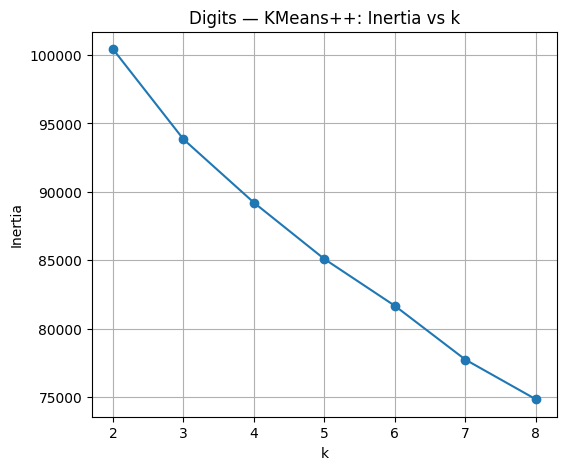

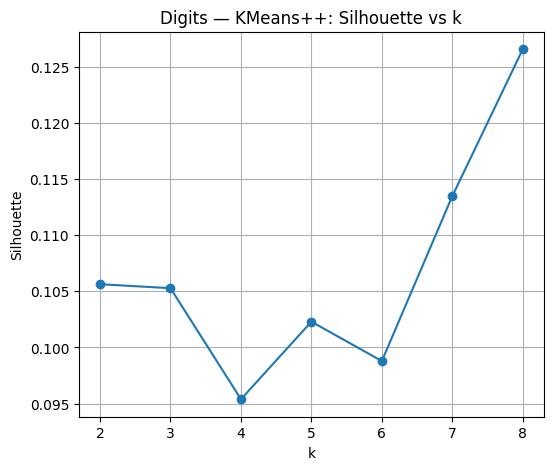

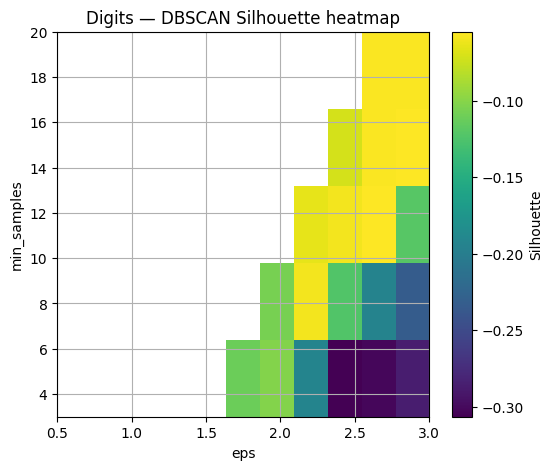

In [ ]:

from itertools import product

# Digits standardized
X_dig = data["digits"][1]
y_dig = data["digits"][2]

# --- KMeans k-sweep
k_vals = list(range(2, 9))
km_sil, km_inertia = [], []

for k in k_vals:
    res = run_kmeans(X_dig, k, init="k-means++")
    sil, _, _ = evaluate_labels(X_dig, res["labels"], res["inertia"], y_dig)
    km_sil.append(sil)
    km_inertia.append(res["inertia"])

plt.figure()
plt.plot(k_vals, km_inertia, marker="o")
plt.title("Digits — KMeans++: Inertia vs k")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(k_vals, km_sil, marker="o")
plt.title("Digits — KMeans++: Silhouette vs k")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.show()

# --- DBSCAN grid sweep
eps_list = np.linspace(0.5, 3.0, 11)  # broadened for digits
ms_list = [3,5,10,15,20]
grid = np.zeros((len(ms_list), len(eps_list))) * np.nan

for i, ms in enumerate(ms_list):
    for j, eps in enumerate(eps_list):
        db = DBSCAN(eps=eps, min_samples=ms, n_jobs=-1)
        labels = db.fit_predict(X_dig)
        if len(set(labels)) > 1 and np.any(labels != -1):
            grid[i, j] = silhouette_score(X_dig, labels)

plt.figure()
plt.imshow(grid, aspect="auto", origin="lower", extent=[eps_list[0], eps_list[-1], ms_list[0], ms_list[-1]])
plt.colorbar(label="Silhouette")
plt.title("Digits — DBSCAN Silhouette heatmap")
plt.xlabel("eps"); plt.ylabel("min_samples")
plt.show()



**Reflection (Hyperparameters):**  
**Hardest challenge:** On Digits, the DBSCAN grid is sensitive; many settings collapse to one cluster or label most points as noise. I widened the eps range and used standardized features to stabilize behavior.  
**New insight:** K around 8–10 balances inertia and silhouette for Digits, but gains flatten quickly—evidence that convex partitions hit a ceiling on non-convex, overlapping structures.



## 6. Reflection & Insights

- **Exploration:** PCA gave a faithful first look without over-promising separation (t-SNE can be misleading).  
- **K-Means:** Implementing Bisecting clarified how greedy SSE splits can produce cleaner partitions than a single global k-means run.  
- **DBSCAN/Agglomerative:** DBSCAN’s success hinges on scale; Ward mirrors K-Means on convex clusters but can outperform when K-Means gets bad initializations.  
- **Hyperparameters:** Broad, structured sweeps (not single guesses) revealed plateaus and brittle regions that black-box calls hide.



## 7. Submission

This notebook is self-contained and uses only scikit-learn’s built-in datasets.  
**Filename:** clustering_assignment_aisha_tahir.ipynb

### Top 3 Takeaways
- **Match algorithm to geometry:** Convex vs. non-convex vs. varying density dictates which method will shine.  
- **Scale matters:** Standardization was essential for fair distance-based comparisons and for DBSCAN stability.  
- **Don’t trust a single view:** Combine metrics (ARI, silhouette, inertia) with plots and failure-mode reasoning.
